# Trend Strategy for EURUSD Exchange Rate

The aim of this notebook is to teach you basic concepts about working with time series data in python. Using the EUR/USD exchange rate as an example, we will create a simple trend-following trading signal and analyse its historical simulated performance.

You will then have an opportunity to modify the model's parameters and see how the results change. Does your model perform better or worse?

## Imports

We need to import some packages for this analysis. There are over 100,000 packages for Python, most of them free of charge. Some like pandas or numpy are used widely in data analysis.

In [32]:
import pandas as pd  # for working with dataframes
import numpy as np # for mathematical functions, arrays and more
import matplotlib.pyplot as plt # for visualisations
from matplotlib.ticker import PercentFormatter # for formatting cumulative return chart y-axis as percent 

In [33]:
plt.rcParams["figure.figsize"] = (25/2.54,12.5/2.54)  # set default figure size (width,height) in cm

## Get Exchange Rate Data

Import EURUSD exchange rate data from file __'EURUSD.csv'__. This has been downloaded from the <a href="https://data.ecb.europa.eu/data/data-categories/ecbeurosystem-policy-and-exchange-rates/exchange-rates/reference-rates">European Central Bank</a>. 

I already know it contains a column `Date` with dates in yyyymmdd format which I want to use as index and I want Python to __parse__ or recognise dates. If I didn't know that, I would first import the .csv without the additional parameters, look at the head of the dataframe and then go back and edit my import. 

Alternatively, if the volume of data is large (not the case here) and I didn't want to re-import, indexing and date parsing can also be achieved with separate lines of code after the import.

In [34]:
df = pd.read_csv('EURUSD.csv',index_col='Date')

In [35]:
df.index = pd.to_datetime(df.index,format='%Y%m%d')

## Validate Exchange Rate Data

Let's look at the first two rows of the dataframe.

In [36]:
df.head(2)

,EURUSD
Date,
1999-01-04,1.1789
1999-01-05,1.1790


Check if there are missing values.

In [37]:
df.isna().sum()

EURUSD    62
dtype: int64

There are several ways of dealing with __erroneous__ or __missing__ values:

- __Accept__. If the errors are spikes in data that are not outside the range of possibility, you may choose to accept them, i.e. do nothing;<br><br>
- __Reject__. If the errors are outside the range of possibility or values are missing, you can delete the records with missing values. This can be a problem if your dataset is small to start with;<br><br>
- __Correct__. If you are able to verify the data at source or re-source the data, you can replace erroneous or missing values. For example, if we had access to the EURUSD exchange rate data from Reuters or Bloomberg, we could use that to fill the gaps;<br><br>
- __Replace__ with default values. In case of working with time series, it is common to replace gaps with previous values. Using previous values is preferred here because it doesn't use any forward looking information.

Replace missing values with immediately preceding values using the `ffill` (forward fill) paramater. `inplace=True` edits the original dataframe not its copy.

In [38]:
df.fillna(method='ffill',inplace=True)

If the dataframe contains numerical values, as we expect here, we can analyse data quality using `.describe()`. There appear to be no extreme values in our data:

In [39]:
df.describe()

,EURUSD
count,6824.000000
mean,1.182868
std,0.155372
min,0.825200
25%,1.082700
50%,1.171800
75%,1.300850
max,1.599000


If you are working with a relatively small amount of data, then it is also useful to visualise the data. __Line charts__ are the most useful for visualising __time series__. For other types of charts please take a look at <a href="https://www.data-to-viz.com/">From Data to Viz</a>

<AxesSubplot:xlabel='Date'>

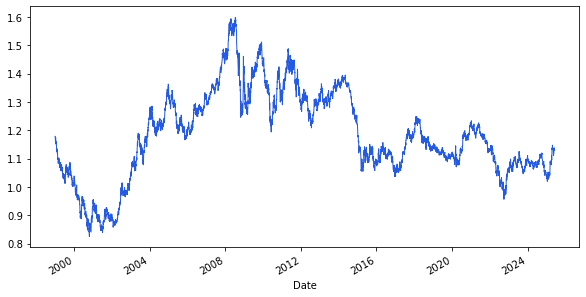

In [40]:
df['EURUSD'].plot(color=['#255be3'],lw=1)

## Create Trading Signals

### Parameters

In [41]:
ma = 200 # moving average length in days
tcost = 0.015/100 # transaction cost from mid in percent. i.e. 0.015/100 means 0.015% or 1.5bp.

### Create Returns

Create function to define moving average crossover signal:

In [42]:
def signal(spot,mavg):
    if spot > mavg:
        s = 1
    elif spot < mavg:
        s = -1
    else:
        s = 0
    return s

Generate rolling mean of signal source and apply `signal` function to each row of the dataframe (there is <a href="https://towardsdatascience.com/apply-function-to-pandas-dataframe-rows-76df74165ee4">more than one way</a> of doing this).

The signal is a quantity of -1 (short EUR and long USD), 1 (long EUR and short USD) or 0 (no position). Using a 200-day moving average cross-over, the signal on 30-May-25 is long EUR because its current value 1.1339 is above the `Mean` of 1.081517, i.e. EUR is trending higher.

In [43]:
df['Mean'] = df['EURUSD'].rolling(ma).mean()
df['Signal'] = df.apply(lambda row: signal(row['EURUSD'], row['Mean']), axis=1)
df.tail(5)

,EURUSD,Mean,Signal
Date,,,
2025-05-26,1.1381,1.080814,1
2025-05-27,1.1356,1.081029,1
2025-05-28,1.1317,1.081222,1
2025-05-29,1.1281,1.081354,1
2025-05-30,1.1339,1.081517,1


Calculate __simulated past spot return__ of the strategy by multiplying T-1 `Signal` and `pct_change()` of `Close` from T-1 to T and subtract costs. Costs are charged on the notional amount you need to trade to change the signal, i.e if the signal switches from -1 to 1, you need to trade 2x notional amount of the strategy, hence the absolute difference. Add return to new column `Return`.

In [44]:
df['Return'] = df['Signal'].shift(1) * df['EURUSD'].pct_change() - abs(df['Signal'].diff()) * tcost
df.tail(5)

,EURUSD,Mean,Signal,Return
Date,,,,
2025-05-26,1.1381,1.080814,1,0.007079
2025-05-27,1.1356,1.081029,1,-0.002197
2025-05-28,1.1317,1.081222,1,-0.003434
2025-05-29,1.1281,1.081354,1,-0.003181
2025-05-30,1.1339,1.081517,1,0.005141


### Analyse Returns

Plot <font color='red'>cumulative strategy return</font>.

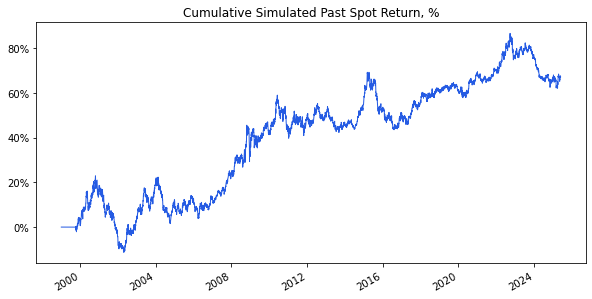

In [45]:
ax = df['Return'].cumsum().plot(color=['#255be3'],lw=1,title='Cumulative Simulated Past Spot Return, %')
plt.xlabel(None)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=0))

Add __rolling drawdown__ to the dataframe. A drawdown is the return an investor would have subsequently experienced by investing in the strategy at the previous high watermark in the cumulative return.

This is calculated as the difference between the cumulative return and maximum cumulative return observed to-date. Because our cumulative return is a sum of daily returns without reinvestment (i.e. not a compounded return index), we take a linear rather than percent difference.

In [46]:
df['Drawdown'] = df['Return'].cumsum() - df['Return'].cumsum().expanding(1).max()

Plot <font color='red'>rolling drawdown</font>.

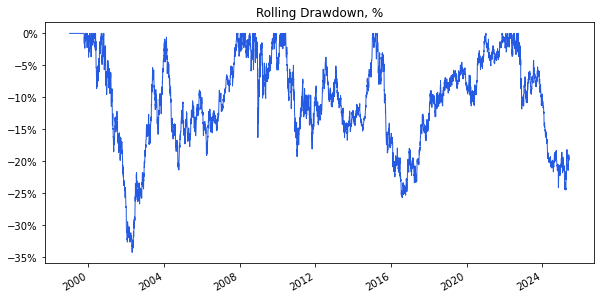

In [47]:
ax = df['Drawdown'].plot(color=['#255be3'],lw=1,title='Rolling Drawdown, %')
plt.xlabel(None)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=0))

Calculate <font color='red'>return statistics</font>.

Because our returns are zero before the moving average and the signal can be calculated, we want to exclude them from the return calculation to avoid skewing the result.

In [48]:
def return_stats(s):
    
    a_ret = 260 * df[df.index >= df['Mean'].first_valid_index()][s].mean()
    a_vol = np.sqrt(260) * df[df.index >= df['Mean'].first_valid_index()][s].std()
    inf_ratio = a_ret / a_vol
    max_dd = df['Drawdown'].min()
    
    print ('Annual Return: %s' % '{:.2%}'.format(a_ret))
    print ('Annual StDev: %s' % '{:.2%}'.format(a_vol))
    print ('Information Ratio: %s' % '{:.2f}'.format(inf_ratio) if inf_ratio >=0 else 'Information Ratio: n/a')
    print ('Max Drawdown: %s' % '{:.2%}'.format(max_dd))

In [49]:
return_stats('Return')

Annual Return: 2.64%
Annual StDev: 9.48%
Information Ratio: 0.28
Max Drawdown: -34.23%


You want a strategy with a __positive information ratio__, ideally __around 0.5 or higher__. This means that for each unit of risk, the strategy has generated 0.5 units of return. The maximum drawdown should ideally not be more than a few multiples of the annual return.

It is common practice not to show information ratios for strategies that have lost money. Our aim is to analyse how consistently the strategy has generated profits, not losses!

## Next Steps

The previous exercise shows that creating a profitable trend following trading strategy in EURUSD is a challenge. In order to practice your Python skills, please try the following:

1) Play around with the __parameters__ and observe how they change performance.
 - How do the results change if you change the `ma` and `tcost` parameters? Have shorter moving average lengths produced better or worse historical simulations? Are the simulation results sensitive to the level of assumed transaction costs?
 - Write a data mining loop that cycles through a range of `ma` parameters and records performance statistics for each parameter. What do you observe?
 - If you want to challenge yourself, replace the arithmetic average with an exponentially weighted average in the trend signal calculation. Does it give better or worse simulation results?
 
2) Change the `signal` function to trade __mean reversion__ instead of trend. How do the results change?

3) Consider sourcing more exchange rate data from the European Central Bank reference rates or any other source and implement the strategy in a __portfolio__ of currency pairs. Do additional currency pairs bring diversification and how do performance statistics on the portfolio level compare to currency level?

I hope you have enjoyed this simple example of how to create a currency trading strategy. For the next __advanced__ level challenges consider implementing the trading strategy in EURUSD forwards or futures instead of spot. A real-life implementation of the signal would also incur the cost or benefit of the interest rate differential between EUR and USD.

If you have access to intraday data, consider generating the signal and notional trading at different times of day, allowing for a realistic gap between observing the signal and implementing it. Fixing data published by Bloomberg (BFIX) or Refinitiv (WMR) can be useful for that.

If you have access to transaction cost and execution slippage data, consider using variable transaction costs for your applicable strategy notional amount. However, this data is quite hard to come by and you may have to wait until your first job to implement that!